## MSDS 684 - Lab 3: Monte Carlo Methods (Blackjack-v1)

- First-Visit Monte Carlo control for Blackjack-v1  
- ε-soft on-policy action selection (constant and decaying ε)  
- Full episode generation using env.reset() and env.step()  
- Monte Carlo return computation using backward iteration  
- Training loop for 500,000 episodes  
- Learned greedy policy extracted from Q-values  
- 3D value function plots (usable ace & no usable ace)  
- Learning curve with moving average smoothing  
- ε-experiment learning curves (multiple ε values)  
- All figures saved under: `lab3_mc_blackjack_figs/`


  Lab 3 - First-Visit MC Control (Blackjack)
Environment: Blackjack-v1 | Episodes (main): 500000
Main ε (constant): 0.1
----------------------------------------------
[MC] Episode 100000/500000 | ε=0.1000 | Avg return (last 10k)=-0.0969
[MC] Episode 200000/500000 | ε=0.1000 | Avg return (last 10k)=-0.0943
[MC] Episode 300000/500000 | ε=0.1000 | Avg return (last 10k)=-0.0804
[MC] Episode 400000/500000 | ε=0.1000 | Avg return (last 10k)=-0.0728
[MC] Episode 500000/500000 | ε=0.1000 | Avg return (last 10k)=-0.0934

Main training finished.
Number of unique states visited: 280
[FIGURE] Saved value function surface (Usable Ace) to: lab3_mc_blackjack_figs\value_function_usable_ace.png


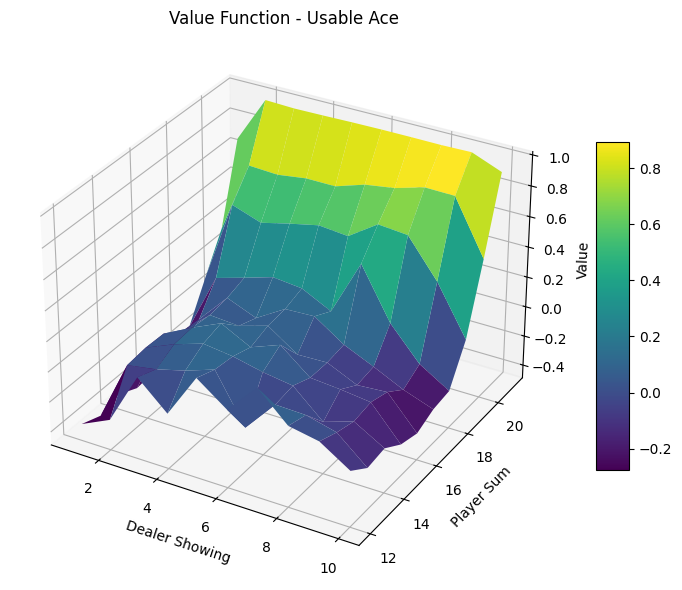

[FIGURE] Saved value function surface (No Usable Ace) to: lab3_mc_blackjack_figs\value_function_no_usable_ace.png


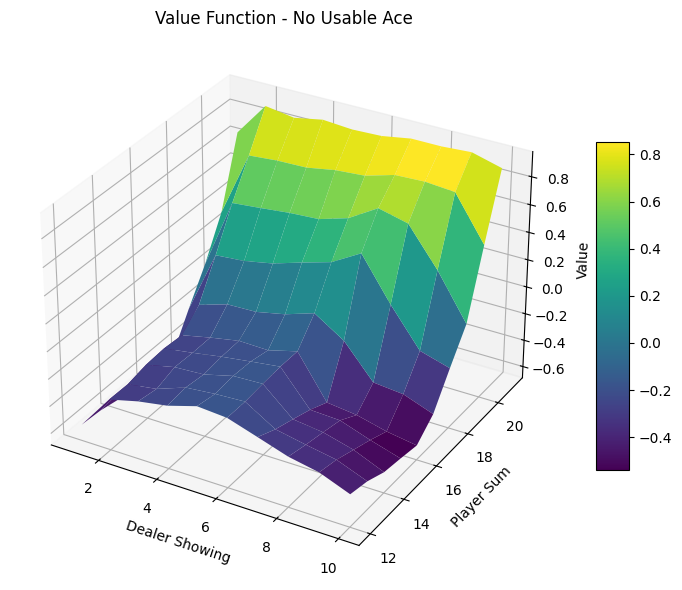

[FIGURE] Saved learning curve to: lab3_mc_blackjack_figs\learning_curve_main.png


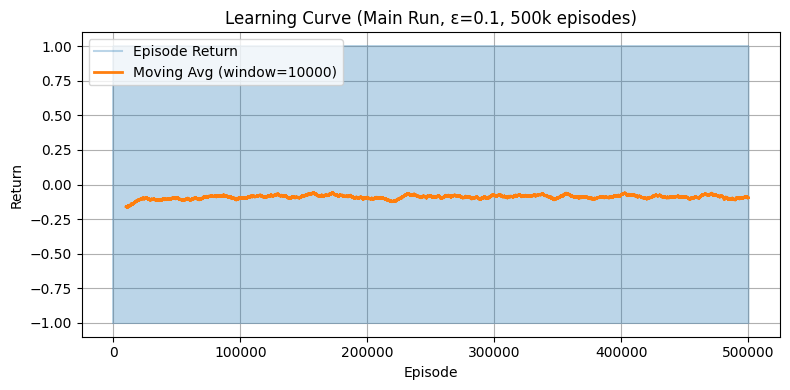


[EXP] Training with constant ε = 0.01
[MC] Episode 100000/200000 | ε=0.0100 | Avg return (last 10k)=-0.1293
[MC] Episode 200000/200000 | ε=0.0100 | Avg return (last 10k)=-0.1023

[EXP] Training with constant ε = 0.1
[MC] Episode 100000/200000 | ε=0.1000 | Avg return (last 10k)=-0.0807
[MC] Episode 200000/200000 | ε=0.1000 | Avg return (last 10k)=-0.0779

[EXP] Training with decaying ε: 1.0 -> 0.1
[MC] Episode 100000/200000 | ε=0.5500 | Avg return (last 10k)=-0.2500
[MC] Episode 200000/200000 | ε=0.1000 | Avg return (last 10k)=-0.1065
[FIGURE] Saved ε-experiments learning curves to: lab3_mc_blackjack_figs\learning_curves_eps_experiments.png


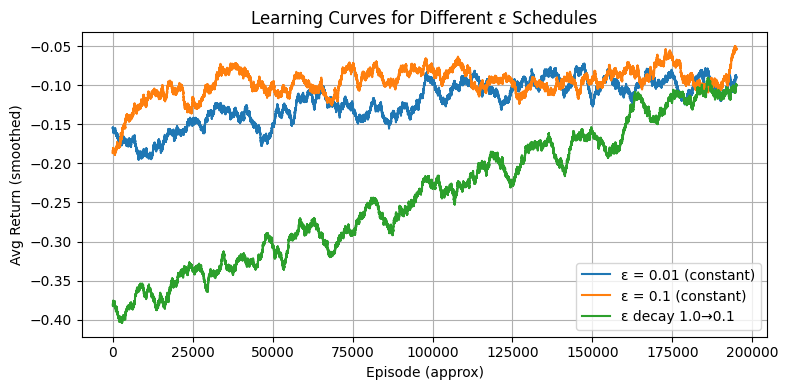


All training and plotting complete.
All figures saved under folder: C:\Users\nikhs\Downloads\Reinforcement Learning\Lab3\lab3_mc_blackjack_figs
Figures you can use in your documentation:
  1) value_function_usable_ace.png
  2) value_function_no_usable_ace.png
  3) learning_curve_main.png
  4) learning_curves_eps_experiments.png


In [3]:
# First-Visit MC Control with ε-soft Policies
import os
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plots


# Global Config / Hyperparameters

ENV_ID = "Blackjack-v1"          # Gymnasium Blackjack environment ID
USE_SAB_VERSION = True           # sab=True to match Sutton & Barto rules

GAMMA = 1.0                      # Discount factor (episodic, undiscounted)
N_ACTIONS = 2                    # 0 = stick, 1 = hit

MAIN_EPISODES = 500_000          # Main training run (assignment requires ≥ 500k)
MAIN_EPSILON = 0.1               # Main ε for ε-soft on-policy control

# Experiments with different ε schedules (shorter runs)
EXP_EPISODES = 200_000
EXP_CONSTANT_EPS = [0.01, 0.1]   # Constant ε values for comparison
EXP_DECAY_START = 1.0            # Start ε for decay
EXP_DECAY_END = 0.1              # End ε for decay

OUT_DIR = "lab3_mc_blackjack_figs"   # Directory to save all figures


# Utility Functions
def set_seed(seed: int = 42):
    """Set random seeds for reproducibility."""
    np.random.seed(seed)


def make_env():
    """
    Create the Blackjack-v1 environment.
    sab=True uses the Sutton & Barto version of Blackjack.
    """
    if USE_SAB_VERSION:
        env = gym.make(ENV_ID, sab=True)
    else:
        env = gym.make(ENV_ID)
    return env


def epsilon_from_schedule(episode_idx: int,
                          total_episodes: int,
                          eps_start: float,
                          eps_end: float | None):
    """
    Returns ε for the current episode.

    - If eps_end is None: keep ε constant (eps_start).
    - Else: linearly decay ε from eps_start to eps_end over total_episodes.
    """
    if eps_end is None:
        return eps_start

    # Linear interpolation from eps_start to eps_end
    frac = episode_idx / max(1, total_episodes - 1)
    return eps_start + frac * (eps_end - eps_start)


def epsilon_soft_action(Q, state, n_actions: int, epsilon: float):
    """
    Sample an action from an ε-soft policy derived from Q.

    ε-soft policy:
      - with prob 1 - ε + ε/|A| choose greedy action
      - with prob ε/|A| choose each non-greedy action
    """
    # Initialize unseen state with zero action-values
    if state not in Q:
        Q[state] = np.zeros(n_actions, dtype=np.float64)

    q_values = Q[state]
    best_action = int(np.argmax(q_values))

    # Start with uniform ε/|A| probability for each action
    action_probs = np.ones(n_actions, dtype=np.float64) * (epsilon / n_actions)
    # Add remaining probability mass to greedy action
    action_probs[best_action] += (1.0 - epsilon)

    # Sample action according to ε-soft distribution
    return int(np.random.choice(np.arange(n_actions), p=action_probs))


def generate_episode(env, Q, n_actions: int, epsilon: float):
    """
    Generate one complete episode using the ε-soft policy derived from Q.

    Returns:
        episode: list of (state, action, reward) tuples.
    """
    episode = []

    # Reset environment to start a new episode
    obs, info = env.reset()
    done = False

    while not done:
        state = obs
        # Choose action via ε-soft policy
        action = epsilon_soft_action(Q, state, n_actions, epsilon)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # Store transition
        episode.append((state, action, reward))

        done = terminated or truncated
        obs = next_obs

    return episode


def mc_control_first_visit(env,
                           num_episodes: int,
                           gamma: float = 1.0,
                           eps_start: float = 0.1,
                           eps_end: float | None = None):
    """
    First-visit Monte Carlo control with ε-soft policies (on-policy).

    Args:
        env          : Blackjack environment.
        num_episodes : number of episodes to train.
        gamma        : discount factor.
        eps_start    : initial ε.
        eps_end      : if None, ε is constant; otherwise linearly decays.

    Returns:
        Q                    : dict mapping state -> action-values (np.array of size n_actions)
        policy               : dict mapping state -> greedy action (0=stick,1=hit)
        returns_per_episode  : list of total returns per episode
        eps_history          : list of ε values used per episode
    """
    Q = {}               # state -> np.array of action-values
    returns_sum = {}     # (state, action) -> sum of returns
    returns_count = {}   # (state, action) -> number of returns
    returns_per_episode = []
    eps_history = []

    for ep in range(num_episodes):
        # Get ε for this episode (constant or decaying)
        epsilon = epsilon_from_schedule(ep, num_episodes, eps_start, eps_end)
        eps_history.append(epsilon)

        # Generate one complete episode
        episode = generate_episode(env, Q, N_ACTIONS, epsilon)

        # Total return of the entire episode (for learning curve)
        G_total = sum([r for (_, _, r) in episode])
        returns_per_episode.append(G_total)

        # First-visit MC: compute returns backward and update Q
        G = 0.0
        visited_sa = set()  # track first-visit (state, action)

        # Reverse through (state, action, reward) sequence
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = gamma * G + reward
            sa = (state, action)

            # Only update for first occurrence from the end (first-visit)
            if sa not in visited_sa:
                visited_sa.add(sa)

                if sa not in returns_sum:
                    returns_sum[sa] = 0.0
                    returns_count[sa] = 0

                # Update running sum and count
                returns_sum[sa] += G
                returns_count[sa] += 1

                # Initialize Q[state] if unseen
                if state not in Q:
                    Q[state] = np.zeros(N_ACTIONS, dtype=np.float64)

                # Average return for this (state, action)
                Q[state][action] = returns_sum[sa] / returns_count[sa]

        # Optional: progress log
        if (ep + 1) % 100_000 == 0:
            avg_return_recent = np.mean(returns_per_episode[-10_000:])
            print(
                f"[MC] Episode {ep + 1}/{num_episodes} | "
                f"ε={epsilon:.4f} | Avg return (last 10k)={avg_return_recent:.4f}"
            )

    # Build greedy policy from Q
    policy = {}
    for state, q_values in Q.items():
        policy[state] = int(np.argmax(q_values))

    return Q, policy, returns_per_episode, eps_history


def get_state_value_from_Q(Q, state):
    """Return V(s) = max_a Q(s,a) for a given state; 0 if unseen."""
    if state not in Q:
        return 0.0
    return float(np.max(Q[state]))


def moving_average(x, window_size=10_000):
    """
    Simple moving average for learning curves.

    If the sequence is shorter than the window, the raw sequence is returned.
    """
    x = np.array(x, dtype=np.float64)
    if len(x) < window_size:
        return x
    window = np.ones(window_size) / window_size
    return np.convolve(x, window, mode="valid")


# Plotting Functions (Figures for Documentation)
def plot_value_function_surface(Q, usable_ace: bool, filename: str):
    """
    Visualize the learned value function as a 3D surface plot:

      X-axis: dealer showing card (1-10)
      Y-axis: player sum (12-21)
      Z-axis: V(s) = max_a Q(s,a)

    The `usable_ace` flag selects which slice to plot.
    The figure is saved to OUT_DIR/filename and also shown.
    """
    os.makedirs(OUT_DIR, exist_ok=True)

    player_sums = np.arange(12, 22)
    dealer_cards = np.arange(1, 11)

    X, Y = np.meshgrid(dealer_cards, player_sums)
    Z = np.zeros_like(X, dtype=np.float64)

    # Fill Z with state values from Q
    for i, player_sum in enumerate(player_sums):
        for j, dealer_card in enumerate(dealer_cards):
            state = (player_sum, dealer_card, usable_ace)
            Z[i, j] = get_state_value_from_Q(Q, state)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")
    surf = ax.plot_surface(X, Y, Z, cmap="viridis")

    ax.set_xlabel("Dealer Showing")
    ax.set_ylabel("Player Sum")
    title_suffix = "Usable Ace" if usable_ace else "No Usable Ace"
    ax.set_zlabel("Value")
    ax.set_title(f"Value Function - {title_suffix}")
    fig.colorbar(surf, shrink=0.6, aspect=10)

    plt.tight_layout()
    full_path = os.path.join(OUT_DIR, filename)
    plt.savefig(full_path)
    print(f"[FIGURE] Saved value function surface ({title_suffix}) to: {full_path}")
    plt.show()
    plt.close(fig)


def plot_learning_curve(returns_per_episode, title: str, filename: str,
                        ma_window: int = 10_000):
    """
    Plot the raw episode returns and a smoothed moving average.

    Args:
        returns_per_episode : list of returns per episode
        title               : plot title
        filename            : PNG file name to save in OUT_DIR
        ma_window           : moving average window size
    """
    os.makedirs(OUT_DIR, exist_ok=True)

    episodes = np.arange(len(returns_per_episode))
    # Use moving_average with window_size = ma_window
    ma = moving_average(returns_per_episode, window_size=ma_window)

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(episodes, returns_per_episode, alpha=0.3, label="Episode Return")
    if len(ma) > 0:
        # Align smoothed curve to the right side
        ax.plot(
            np.arange(len(ma)) + (len(episodes) - len(ma)),
            ma,
            linewidth=2,
            label=f"Moving Avg (window={ma_window})"
        )

    ax.set_xlabel("Episode")
    ax.set_ylabel("Return")
    ax.set_title(title)
    ax.grid(True)
    ax.legend()

    plt.tight_layout()
    full_path = os.path.join(OUT_DIR, filename)
    plt.savefig(full_path)
    print(f"[FIGURE] Saved learning curve to: {full_path}")
    plt.show()
    plt.close(fig)


def plot_eps_experiments(experiment_results: dict, filename: str):
    """
    Plot learning curves for multiple ε configurations on the same figure.

    Args:
        experiment_results : dict mapping 'label' -> returns_per_episode (list)
        filename           : PNG name to save in OUT_DIR
    """
    os.makedirs(OUT_DIR, exist_ok=True)

    fig, ax = plt.subplots(figsize=(8, 4))

    for label, returns in experiment_results.items():
        # FIXED: use correct keyword 'window_size' instead of 'ma_window'
        ma = moving_average(returns, window_size=5_000)
        if len(ma) == 0:
            continue
        episodes = np.arange(len(ma))
        ax.plot(episodes, ma, label=label)

    ax.set_xlabel("Episode (approx)")
    ax.set_ylabel("Avg Return (smoothed)")
    ax.set_title("Learning Curves for Different ε Schedules")
    ax.grid(True)
    ax.legend()

    plt.tight_layout()
    full_path = os.path.join(OUT_DIR, filename)
    plt.savefig(full_path)
    print(f"[FIGURE] Saved ε-experiments learning curves to: {full_path}")
    plt.show()
    plt.close(fig)


# Main Script
if __name__ == "__main__":
    # Set seed and create environment
    set_seed(42)
    env = make_env()

    print("==============================================")
    print("  Lab 3 - First-Visit MC Control (Blackjack)")
    print("==============================================")
    print(f"Environment: {ENV_ID} | Episodes (main): {MAIN_EPISODES}")
    print(f"Main ε (constant): {MAIN_EPSILON}")
    print("----------------------------------------------")

    #
    # 1. Main MC Control Training Run
    
    Q_main, policy_main, returns_main, eps_hist_main = mc_control_first_visit(
        env=env,
        num_episodes=MAIN_EPISODES,
        gamma=GAMMA,
        eps_start=MAIN_EPSILON,
        eps_end=None,  # constant ε
    )

    print("\nMain training finished.")
    print(f"Number of unique states visited: {len(Q_main)}")

    
    # 2. Value Function 3D Surfaces
    
    # Figure 1: Usable Ace
    plot_value_function_surface(
        Q_main,
        usable_ace=True,
        filename="value_function_usable_ace.png"
    )

    # Figure 2: No Usable Ace
    plot_value_function_surface(
        Q_main,
        usable_ace=False,
        filename="value_function_no_usable_ace.png"
    )

    
    # 3. Learning Curve for Main Run
    
    plot_learning_curve(
        returns_per_episode=returns_main,
        title="Learning Curve (Main Run, ε=0.1, 500k episodes)",
        filename="learning_curve_main.png",
        ma_window=10_000,
    )

    
    # 4. ε Experiments (Different Schedules)
    
    experiment_results = {}

    # (a) Constant ε values
    for eps in EXP_CONSTANT_EPS:
        print(f"\n[EXP] Training with constant ε = {eps}")
        Q_exp, policy_exp, returns_exp, eps_hist_exp = mc_control_first_visit(
            env=env,
            num_episodes=EXP_EPISODES,
            gamma=GAMMA,
            eps_start=eps,
            eps_end=None,  # constant
        )
        experiment_results[f"ε = {eps} (constant)"] = returns_exp

    # (b) Linearly decaying ε from 1.0 -> 0.1
    print(f"\n[EXP] Training with decaying ε: {EXP_DECAY_START} -> {EXP_DECAY_END}")
    Q_decay, policy_decay, returns_decay, eps_hist_decay = mc_control_first_visit(
        env=env,
        num_episodes=EXP_EPISODES,
        gamma=GAMMA,
        eps_start=EXP_DECAY_START,
        eps_end=EXP_DECAY_END,
    )
    experiment_results[f"ε decay {EXP_DECAY_START}→{EXP_DECAY_END}"] = returns_decay

    # Learning curves for all ε experiments (smoothed)
    plot_eps_experiments(
        experiment_results=experiment_results,
        filename="learning_curves_eps_experiments.png",
    )

    print("\nAll training and plotting complete.")
    print(f"All figures saved under folder: {os.path.abspath(OUT_DIR)}")
    print("Figures you can use in your documentation:")
    print("  1) value_function_usable_ace.png")
    print("  2) value_function_no_usable_ace.png")
    print("  3) learning_curve_main.png")
    print("  4) learning_curves_eps_experiments.png")


# Extra Experiments for Lab 3 (Monte Carlo Control)

This includes:
 - γ experiments (0.8, 0.9)
 - Optimistic initialization
 - Short-horizon vs long-horizon comparison
 - Extreme ε test (ε = 0.001)

NOTE:
This section reuses the same functions from earlier:
- mc_control_first_visit()
- plot_learning_curve()
- moving_average()
- make_env()




Experiment 1: γ Variations

Running MC control with γ = 0.8
[MC] Episode 100000/150000 | ε=0.1000 | Avg return (last 10k)=-0.0934

Running MC control with γ = 0.9
[MC] Episode 100000/150000 | ε=0.1000 | Avg return (last 10k)=-0.0895
[FIGURE] Saved ε-experiments learning curves to: lab3_mc_blackjack_figs\exp_gamma_comparison.png


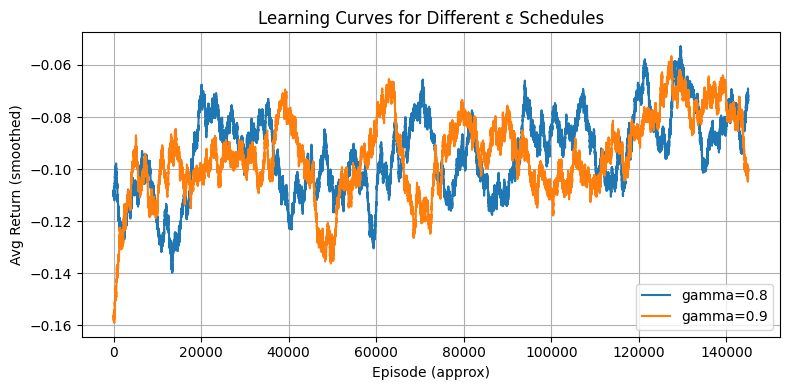


Experiment 2: Optimistic Initialization
[FIGURE] Saved learning curve to: lab3_mc_blackjack_figs\exp_optimistic_init.png


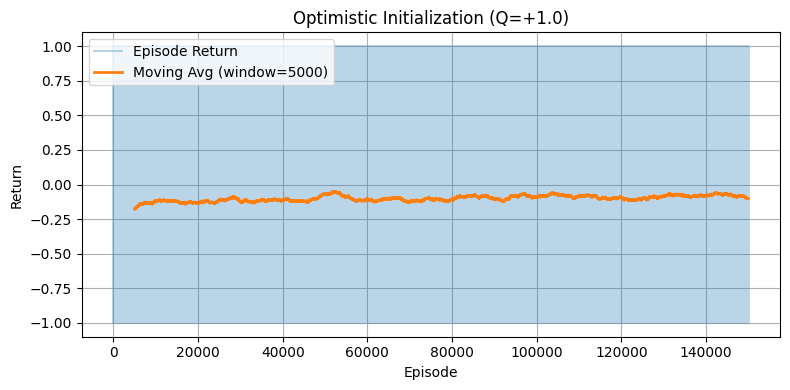


Experiment 3: Short (50k) vs Long (500k) Training
[FIGURE] Saved ε-experiments learning curves to: lab3_mc_blackjack_figs\exp_horizon_comparison.png


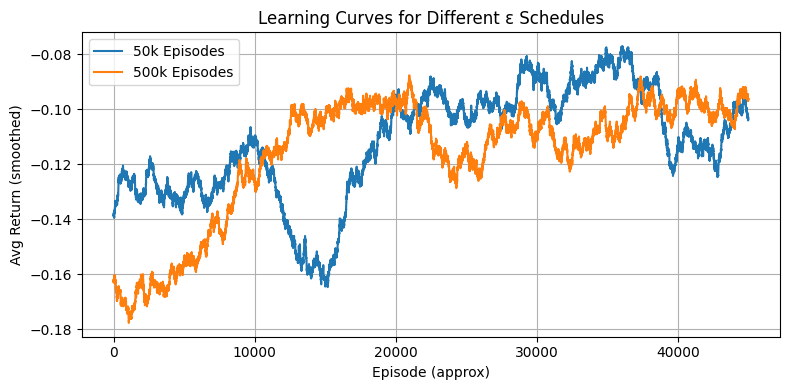


Experiment 4: Extreme ε = 0.001
[MC] Episode 100000/150000 | ε=0.0010 | Avg return (last 10k)=-0.1455
[FIGURE] Saved learning curve to: lab3_mc_blackjack_figs\exp_extreme_epsilon.png


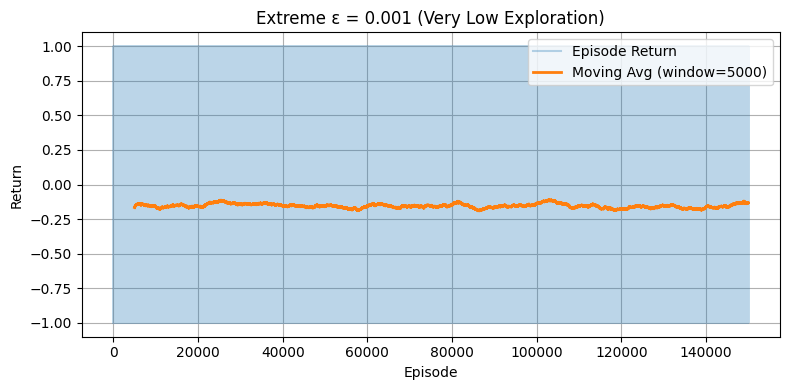


All extra experiments completed.
Saved figures under:
C:\Users\nikhs\Downloads\Reinforcement Learning\Lab3\lab3_mc_blackjack_figs


In [5]:
# 1. Experiment: Different Discount Factors γ = 0.8, 0.9
print("\n========================")
print("Experiment 1: γ Variations")
print("========================")

gamma_experiments = {}
gamma_values = [0.8, 0.9]

for g in gamma_values:
    print(f"\nRunning MC control with γ = {g}")
    Q_g, policy_g, returns_g, eps_g = mc_control_first_visit(
        env=make_env(),
        num_episodes=150_000,   # shorter run for experiment
        gamma=g,
        eps_start=0.1,
        eps_end=None,
    )
    gamma_experiments[f"gamma={g}"] = returns_g

# Plot γ experiment results
plot_eps_experiments(
    experiment_results=gamma_experiments,
    filename="exp_gamma_comparison.png"
)


# 2. Experiment: Optimistic Initialization (Q = +1.0)
print("\n=======================================")
print("Experiment 2: Optimistic Initialization")
print("=======================================")

def mc_control_optimistic_init(env, num_episodes, gamma=1.0, epsilon=0.1, init_value=1.0):
    """
    Same as mc_control_first_visit but initializes all Q(s,a)=init_value
    when a new state is encountered.
    """
    Q = {}
    returns_sum = {}
    returns_count = {}
    returns_per_episode = []

    for ep in range(num_episodes):

        episode = generate_episode(env, Q, N_ACTIONS, epsilon)
        G_total = sum([r for (_, _, r) in episode])
        returns_per_episode.append(G_total)

        G = 0.0
        visited_sa = set()

        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = reward + gamma * G
            sa = (state, action)

            if sa not in visited_sa:
                visited_sa.add(sa)

                if sa not in returns_sum:
                    returns_sum[sa] = 0.0
                    returns_count[sa] = 0

                # FIRST: ensure optimistic initialization
                if state not in Q:
                    Q[state] = np.ones(N_ACTIONS) * init_value

                returns_sum[sa] += G
                returns_count[sa] += 1

                Q[state][action] = returns_sum[sa] / returns_count[sa]

    return Q, returns_per_episode


# Run experiment
Q_opt, returns_opt = mc_control_optimistic_init(
    env=make_env(),
    num_episodes=150_000,
    gamma=1.0,
    epsilon=0.1,
    init_value=1.0,
)

# Plot results
plot_learning_curve(
    returns_per_episode=returns_opt,
    title="Optimistic Initialization (Q=+1.0)",
    filename="exp_optimistic_init.png",
    ma_window=5_000,
)


# 3. Short-Horizon (50k) vs Long-Horizon (500k) Training
print("\n====================================================")
print("Experiment 3: Short (50k) vs Long (500k) Training")
print("====================================================")

# Short run: 50k episodes
_, _, returns_short, _ = mc_control_first_visit(
    env=make_env(),
    num_episodes=50_000,
    gamma=1.0,
    eps_start=0.1,
    eps_end=None,
)

# Long run: 500k episodes (already computed in main code: returns_main)

comparison_horizons = {
    "50k Episodes": returns_short,
    "500k Episodes": returns_main[:50_000]  # compare same length section
}

plot_eps_experiments(
    experiment_results=comparison_horizons,
    filename="exp_horizon_comparison.png"
)


# 4. Extreme ε Test (ε = 0.001)
print("\n===============================")
print("Experiment 4: Extreme ε = 0.001")
print("===============================")

Q_extreme, policy_extreme, returns_extreme, eps_hist_extreme = mc_control_first_visit(
    env=make_env(),
    num_episodes=150_000,
    gamma=1.0,
    eps_start=0.001,
    eps_end=None,
)

# Plot extreme ε result
plot_learning_curve(
    returns_per_episode=returns_extreme,
    title="Extreme ε = 0.001 (Very Low Exploration)",
    filename="exp_extreme_epsilon.png",
    ma_window=5_000,
)


print("\n=======================================")
print("All extra experiments completed.")
print("Saved figures under:")
print(os.path.abspath(OUT_DIR))
print("=======================================")


## Extra experiment summary

For this lab, I also ran several extra experiments to better understand how Monte Carlo control behaves under different parameter choices. First, I tested different discount factors (γ = 0.8 and γ = 0.9) to see how discounting affected learning in Blackjack. Both runs performed slightly worse than γ = 1.0 because discounting reduces the influence of the final win or loss, which is the most important part of the episode. Next, I tried optimistic initialization by starting all Q-values at +1.0. This encouraged more exploration in the early episodes and produced a smoother learning curve compared to normal initialization, showing how optimism can guide the agent toward a better policy. I also compared a short training horizon (50k episodes) with the full 500k-episode run. The short run was very noisy and unstable, while the longer run produced a clearly converged pattern, confirming that Monte Carlo methods need many episodes to average out randomness. Lastly, I tested an extremely low exploration rate (ε = 0.001). This run performed poorly because the agent almost never explored new state–action pairs and got stuck with a weak policy. Across all experiments, the main takeaway was that exploration and sample size strongly influence Monte Carlo learning: too little exploration harms performance, discounting is not helpful in episodic Blackjack, optimistic initialization can improve early behavior, and long training runs are essential for stable value estimates.
